In [1]:
from fastai import *
from fastai.text import*
import pandas as pd
import os

In [2]:
#bs = 192
bs = 48
os.chdir("C:/Users/Administrator/Desktop/fine_tuning")
path = Path("C:/Users/Administrator/Desktop/fine_tuning")

In [51]:
#df = pd.read_pickle("tune_reviews.pkl")
df = pd.read_pickle("language_model_data.pkl")
former_data = load_data(path,"fine_tuned_data")

In [ ]:
#former_data.vocab
data_lm = TextList.from_df(df,cols="reviews.text",vocab=former_data.vocab).split_by_rand_pct(0.1,123).label_for_lm()

In [5]:
data_lm = data_lm.databunch(bs=bs,num_workers=8)

In [30]:
data_lm.train_ds.y[0]
data_lm.vocab.load("v")

In [7]:
data_lm.save()

In [31]:
learn_lm = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3).to_fp16()


In [33]:
learn_lm.load_encoder("lm_fine_tuned_enc1")
#len(data_lm.vocab.itos)

RuntimeError: Error(s) in loading state_dict for AWD_LSTM:
	size mismatch for encoder.weight: copying a param with shape torch.Size([31224, 400]) from checkpoint, the shape in current model is torch.Size([16776, 400]).
	size mismatch for encoder_dp.emb.weight: copying a param with shape torch.Size([31224, 400]) from checkpoint, the shape in current model is torch.Size([16776, 400]).

In [16]:
data_lm.vocab.stoi["i"]


12

In [17]:
data_lm.vocab.itos[1010]

'noticed'

In [28]:
#data_lm.vocab.load("v")
#enc.weight[data_lm.vocab.stoi["always"]]


In [22]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.09E-02


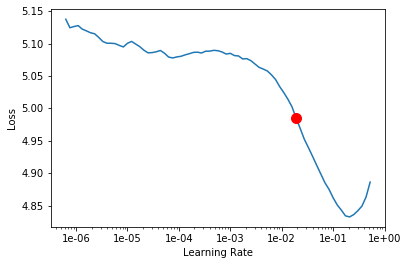

In [23]:
learn_lm.recorder.plot(suggestion=True,skip_end=15)

In [24]:
#lr =5e-3
#lr*=bs/48
#lr

min_grad=learn_lm.recorder.min_grad_lr
min_grad


0.019054607179632484

In [25]:
#learn_lm.fit_one_cycle(1,lr*10,moms=(0.8,0.7))
learn_lm.fit_one_cycle(2,min_grad,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.885044,3.793211,0.287345,00:36
1,3.633281,3.653056,0.302679,00:36


In [22]:
learn_lm.save("lm_fit__new_1")

In [26]:
learn_lm.unfreeze()

In [24]:

#learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


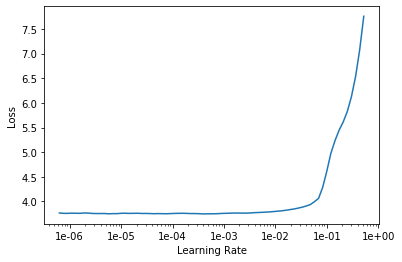

In [25]:
learn_lm.recorder.plot(suggestions=True)

In [26]:
lr

NameError: name 'lr' is not defined

In [27]:
learn_lm.fit_one_cycle(10,5e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.484511,3.604267,0.307433,00:45
1,3.574124,3.646197,0.301420,00:45
2,3.595494,3.667082,0.299465,00:44
3,3.549458,3.651885,0.300888,00:45
4,3.393343,3.627455,0.306073,00:45
5,3.230858,3.621206,0.307370,00:45
6,3.036303,3.634075,0.307963,00:45
7,2.772423,3.684202,0.305921,00:45
8,2.551138,3.742681,0.303649,00:45
9,2.421860,3.780456,0.302066,00:45


In [28]:
learn_lm.save("lm_fine_tuned_new")
learn_lm.save_encoder("lm_fine_tuned_new_enc1")

In [30]:
data_lm.save("fine_tuned_data")

In [9]:
learn_lm.load("lm_fine_tuned3")

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	size mismatch for 0.encoder.weight: copying a param with shape torch.Size([31280, 400]) from checkpoint, the shape in current model is torch.Size([31200, 400]).
	size mismatch for 0.encoder_dp.emb.weight: copying a param with shape torch.Size([31280, 400]) from checkpoint, the shape in current model is torch.Size([31200, 400]).
	size mismatch for 1.decoder.weight: copying a param with shape torch.Size([31280, 400]) from checkpoint, the shape in current model is torch.Size([31200, 400]).
	size mismatch for 1.decoder.bias: copying a param with shape torch.Size([31280]) from checkpoint, the shape in current model is torch.Size([31200]).

In [32]:
data_lm.vocab.save("v")

In [24]:
###try to predict
data_clas = (TextList.from_df(df,cols="reviews.text",vocab=data_lm.vocab).split_by_rand_pct(0.3,seed=44).label_from_df(cols="reviews.rating"))

In [27]:
data_clas = data_clas.databunch(bs=bs,num_workers=8)
                                

In [28]:
learn_c = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.35).to_fp16()

In [29]:
learn_c.load_encoder("lm_fine_tuned_enc1")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (41955 items)
x: TextList
xxbos xxmaj art of xxmaj noise scored some brief xxup mtv airplay off this album in the mid-80 's , then quickly faded away from xxmaj america 's music charts . xxmaj that is unfortunate , as this album is one of the first of its kind . xxmaj an amazing blend of true ' ambient ' sounds ( trucks , xxunk , radio broadcasts ) and electronica , xxmaj art of xxmaj noise was years ahead of the acid jazz and house music that we all take for granted in the 90's . xxmaj any fan of electronic music should check this out . xxmaj very relaxing at times , complex , and singular in its originality .,xxbos xxmaj this item runs large because it is so stretchy . xxmaj other than that it worked great . xxmaj we had used the fleece ones before and bought the cotton one when it started getting warmer .,xxbos xxmaj the xxmaj xxunk is one of the coolest xxup ufo looking military jets the poster arrived fast it was inexpensive & a

In [30]:
learn_c.freeze()

learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.63E-02


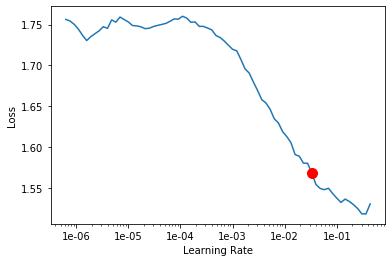

In [32]:
learn_c.recorder.plot(suggestion=True,skip_end=10)

In [34]:
min_grad=learn_c.recorder.min_grad_lr

In [36]:
learn_c.fit_one_cycle(2,min_grad,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.225521,1.163487,0.497831,01:33
1,1.191405,1.113473,0.513626,01:34


In [37]:
learn_c.save("fi_clas")

In [38]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1,slice(5e-3,1e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.096173,1.027205,0.551557,01:40


In [39]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(3,slice(1e-3,5e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.067742,1.030670,0.549333,01:47
1,0.948766,0.980789,0.579978,01:50
2,0.639467,1.099933,0.564294,01:49


In [108]:

preds,y,losses=learn_c_1.get_preds(with_loss=True)


interp = ClassificationInterpretation(learn_c,preds,y,losses)


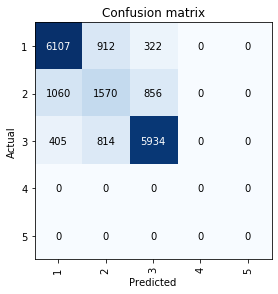

In [109]:
interp.plot_confusion_matrix()

In [48]:
interp.most_confused(min_val=2)

[(1, 2, 1032),
 (4, 5, 953),
 (5, 4, 908),
 (3, 2, 795),
 (2, 1, 764),
 (2, 3, 744),
 (3, 4, 712),
 (4, 3, 603),
 (1, 3, 220),
 (3, 1, 179),
 (3, 5, 164),
 (2, 4, 132),
 (4, 2, 128),
 (5, 3, 128),
 (1, 5, 96),
 (2, 5, 71),
 (5, 1, 60),
 (4, 1, 55),
 (5, 2, 48),
 (1, 4, 43)]

In [49]:
learn_c.save("third_clas")

In [50]:
df.head(1)

,reviews.rating,reviews.summary,reviews.text,text_word_len,text_len_characters,text_character_len,num_nonAlphaN,num_nonEnglish,num_stopwords,num_upperLetters,num_special_characters
773630,4,Sweet revenge,Hollywood releases many heist movies but few c...,136,648,648,18,8,56,56,4


In [51]:
df2 = df.copy()

In [54]:
df2["reviews.rating"].replace({4:5,2:1},inplace=True)

In [69]:
###try to predict
data_clas_a = (TextList.from_df(df2,cols="reviews.text",vocab=data_lm.vocab).split_by_rand_pct(0.3,seed=44).label_from_df(cols="reviews.rating"))

In [70]:
data_clas_a = data_clas_a.databunch(bs=bs,num_workers=8)

In [106]:
data_clas_a.save("polarity_data")

In [71]:
acc_02 = partial(accuracy_thresh,thresh=0.2)
f_score = partial(fbeta,thresh=0.2)

In [97]:
learn_c_1 = text_classifier_learner(data_clas_a,AWD_LSTM,drop_mult=0.35,metrics=[accuracy]).to_fp16()

In [98]:
learn_c_1.load_encoder("lm_fine_tuned_enc1")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (41955 items)
x: TextList
xxbos xxmaj art of xxmaj noise scored some brief xxup mtv airplay off this album in the mid-80 's , then quickly faded away from xxmaj america 's music charts . xxmaj that is unfortunate , as this album is one of the first of its kind . xxmaj an amazing blend of true ' ambient ' sounds ( trucks , xxunk , radio broadcasts ) and electronica , xxmaj art of xxmaj noise was years ahead of the acid jazz and house music that we all take for granted in the 90's . xxmaj any fan of electronic music should check this out . xxmaj very relaxing at times , complex , and singular in its originality .,xxbos xxmaj this item runs large because it is so stretchy . xxmaj other than that it worked great . xxmaj we had used the fleece ones before and bought the cotton one when it started getting warmer .,xxbos xxmaj the xxmaj xxunk is one of the coolest xxup ufo looking military jets the poster arrived fast it was inexpensive & a

In [99]:
learn_c_1.freeze()
learn_c_1.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.74E-02


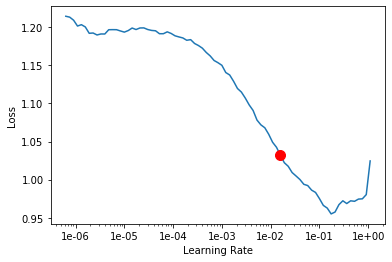

In [100]:
learn_c_1.recorder.plot(suggestion=True)

In [101]:
min_grad=learn_c_1.recorder.min_grad_lr




In [102]:
learn_c_1.fit_one_cycle(6,min_grad,moms=(0.80,0.70))

epoch,train_loss,valid_loss,accuracy,time
0,0.718680,0.685189,0.710234,01:33
1,0.717227,0.657469,0.723304,01:31
2,0.726985,0.664866,0.722636,01:32
3,0.715780,0.663763,0.729088,01:33
4,0.683345,0.630915,0.734205,01:29
5,0.684487,0.629325,0.734816,01:32


In [103]:
learn_c_1.freeze_to(-2)
learn_c_1.fit_one_cycle(4,slice(5e-3,1e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.669995,0.615565,0.743548,01:37
1,0.622011,0.581423,0.760011,01:37
2,0.577133,0.587109,0.761235,01:38
3,0.442255,0.612025,0.760122,01:38


In [104]:
learn_c_1.unfreeze()
learn_c_1.fit_one_cycle(3,slice(5e-4,5e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.527239,0.588969,0.759844,01:52
1,0.407672,0.605742,0.762681,01:58
2,0.181200,0.777062,0.757008,01:57


In [91]:
learn_c_1.save("polarity")

In [92]:
learn_c_1.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


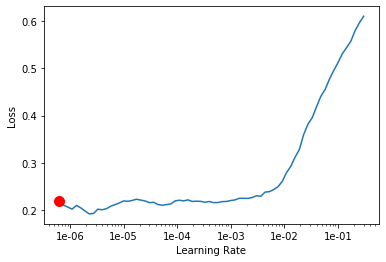

In [93]:
learn_c_1.recorder.plot(suggestion=True)

In [95]:
min_grad=learn_c_1.recorder.min_grad_lr

slice(min_grad)

slice(None, 6.309573444801933e-07, None)

In [96]:
learn_c_1.fit_one_cycle(3,min_grad,moms=(0.8,0.7
                                        ))

epoch,train_loss,valid_loss,accuracy,time
0,0.224733,0.723417,0.757230,01:56
1,0.221219,0.713591,0.756062,01:56
2,0.218508,0.721631,0.752892,01:56


In [105]:
learn_c.save("polarity_3")